<a href="https://colab.research.google.com/github/fauzul91/PKB-Praktikum/blob/main/Modul_7_Reinforcement_Lerarning_(Algoritma_Q_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup Virtual Display, install library dan impor package**

In [ ]:
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display as env
virtual_display = env(visible=0, size=(1400, 900))
virtual_display.start()

!pip install gym==0.24
!pip install pygame
!pip install numpy
!pip install imageio imageio_ffmpeg

import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of addition

# **2. Membuat environment Frozen Lake**

In [ ]:
# Buat environment Frozen Lake
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

# Informasi tentang environment
print("Observation Space:", env.observation_space)
print("Sample observation:", env.observation_space.sample())
print("Action Space Shape:", env.action_space.n)
print("Action Space Sample:", env.action_space.sample())

Observation Space: Discrete(16)
Sample observation: 14
Action Space Shape: 4
Action Space Sample: 0


Penjelasan:
*   Membuat lingkungan "Frozen Lake" dengan ukuran 4x4 tanpa licin.
*   Menampilkan informasi tentang ruang observasi dan ruang aksi.

# **3. Pembuatan dan inisialisasi Q table**

In [ ]:
# Inisialisasi Q-Table
state_space = env.observation_space.n
print("There are ",state_space," possible stats")
action_space = env.action_space.n
print("There are ",action_space," possible stats")

def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)


There are  16  possible stats
There are  4  possible stats


Penjelasan:
*   Membuat tabel Q berukuran [16 x 4] untuk merepresentasikan setiap pasangan state dan action.



# **4. Pembuatan kebijakan Epsilon – Greedy dan kebijakan epsilon**

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    """
    Kebijakan epsilon-greedy: memilih tindakan eksplorasi atau eksploitasi berdasarkan epsilon.
    """
    random_int = random.uniform(0, 1)
    if random_int > epsilon:
        action = np.argmax(Qtable[state])  # Eksploitasi: pilih aksi dengan nilai Q tertinggi
    else:
        action = env.action_space.sample()  # Eksplorasi: pilih aksi acak
    return action

def greedy_policy(Qtable, state):
    """
    Kebijakan greedy: selalu memilih tindakan dengan nilai Q tertinggi.
    """
    action = np.argmax(Qtable[state])  # Eksploitasi penuh
    return action


Penjelasan:
*   Implementasi kebijakan Epsilon-Greedy untuk menentukan apakah agen akan eksplorasi atau eksploitasi.

# **5. Pengaturan hyperparameter training**

In [ ]:
# Training Parameters
n_training_episodes = 10000  # Jumlah episode pelatihan
learning_rate = 0.7         # Kecepatan belajar (alpha)

# Evaluation Parameters
n_eval_episodes = 100       # Jumlah episode evaluasi

# Environment Parameters
env_id = "FrozenLake-v1"    # ID environment yang digunakan
max_steps = 99              # Batas langkah maksimal per episode
gamma = 0.95                # Faktor diskon (gamma)
eval_seed = 1               # Seed untuk evaluasi agar hasil dapat direplikasi

# Exploration Parameters
max_epsilon = 1.0           # Nilai awal epsilon (probabilitas eksplorasi)
min_epsilon = 0.05          # Nilai minimum epsilon (probabilitas eksplorasi minimal)
decay_rate = 0.0005         # Tingkat penurunan epsilon

# **6. Proses Training**

In [ ]:
#Melakukan pelatihan
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in trange(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        for _ in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, _ = env.step(action)
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )
            if done:
                break
            state = new_state
    return Qtable

Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

Penjelasan:
*   Proses pelatihan menggunakan algoritma Q-Learning, di mana Q-Table diperbarui pada setiap iterasi berdasarkan persamaan Bellman.

# **7. Evaluasi Agent**

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed is not None:  # Jika seed diberikan, gunakan seed untuk reproducibility
            state = env.reset(seed=seed)  # Reset environment dengan seed
        else:
            state = env.reset()  # Reset tanpa seed
        total_rewards_ep = 0
        for _ in range(max_steps):
            action = np.argmax(Q[state][:])  # Greedy policy
            new_state, reward, done, _ = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

# Evaluasi agen
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")


Mean reward: 1.00 +/- 0.00


# **8. Visualisasi**

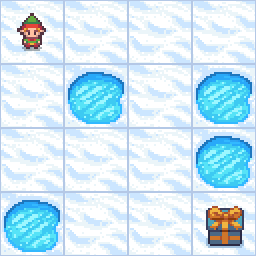

In [ ]:
def record_video(env, Qtable, out_directory, fps=100):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
video_path="/content/replay.gif"
video_fps=100
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')
